<a href="https://colab.research.google.com/github/AP-047/RClass-Classification-by-Rational-Approximation/blob/main/notebooks/milestone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Set Up a Simple Function & Approximation Framework**

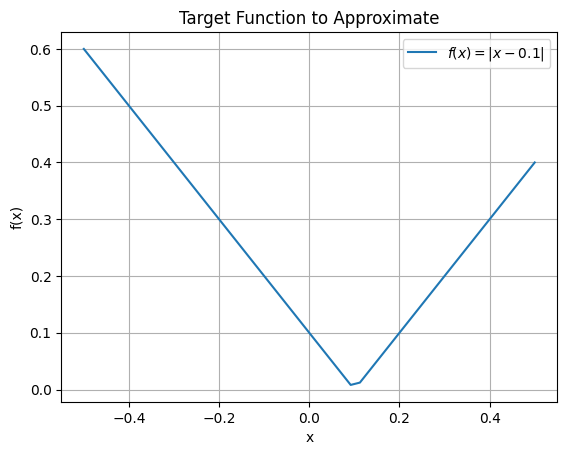

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Define the function to approximate
def f(x):
    return np.abs(x - 0.1)

# Define the interval [a, b] for approximation
a, b = -0.5, 0.5

# Generate discretization points in the interval [a, b]
num_points = 50  # Number of points for evaluation
x_points = np.linspace(a, b, num_points)
y_values = f(x_points)

# Plot the function to visualize it
plt.plot(x_points, y_values, label=r"$f(x) = |x - 0.1|$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Target Function to Approximate")
plt.legend()
plt.grid(True)
plt.show()

**Implement Chebyshev Polynomials & Generate Chebyshev Points**

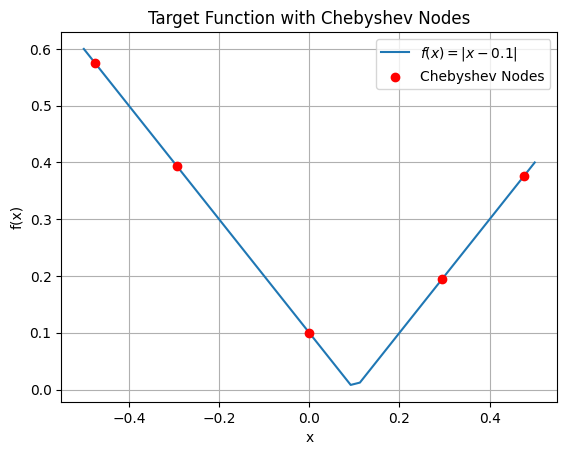

In [2]:
from numpy.polynomial.chebyshev import Chebyshev

# Define the degree of the Chebyshev polynomial
degree = 4

# Generate Chebyshev nodes (roots of Chebyshev polynomial of degree `degree+1`)
def chebyshev_nodes(a, b, degree):
    k = np.arange(1, degree + 2)
    x_chebyshev = np.cos((2 * k - 1) * np.pi / (2 * (degree + 1)))
    # Scale the Chebyshev nodes to the interval [a, b]
    return 0.5 * (b - a) * x_chebyshev + 0.5 * (b + a)

# Calculate Chebyshev polynomials at given points
def chebyshev_polynomials(x, degree):
    polynomials = []
    for d in range(degree + 1):
        T_d = Chebyshev.basis(d)
        polynomials.append(T_d(x))
    return np.array(polynomials).T

# Generate Chebyshev nodes in the interval [a, b]
x_chebyshev = chebyshev_nodes(a, b, degree)

# Evaluate Chebyshev polynomials at the nodes
T_chebyshev = chebyshev_polynomials(x_chebyshev, degree)

# Plot Chebyshev nodes on the function to see their distribution
plt.plot(x_points, y_values, label=r"$f(x) = |x - 0.1|$")
plt.scatter(x_chebyshev, f(x_chebyshev), color='red', label="Chebyshev Nodes", zorder=5)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Target Function with Chebyshev Nodes")
plt.legend()
plt.grid(True)
plt.show()

**Construct the Rational Approximation Function**

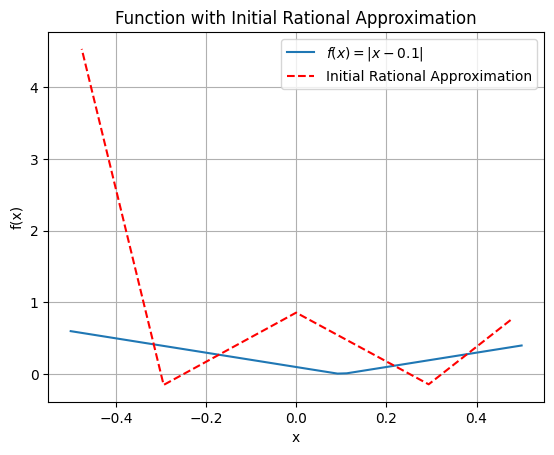

In [3]:
from scipy.optimize import linprog

# Degrees of the numerator and denominator polynomials
n = 4
m = 4

# Generate initial random coefficients for the rational function
# Start with random coefficients; later, we'll optimize these
p_coeffs = np.random.rand(n + 1)  # Coefficients for numerator (degree n)
q_coeffs = np.random.rand(m + 1)  # Coefficients for denominator (degree m)

# Define the rational approximation function r(x) = p(x) / q(x)
def rational_approximation(x, p_coeffs, q_coeffs):
    # Evaluate numerator and denominator polynomials
    p_x = sum(p * T for p, T in zip(p_coeffs, chebyshev_polynomials(x, n)))
    q_x = sum(q * T for q, T in zip(q_coeffs, chebyshev_polynomials(x, m)))
    return p_x / q_x

# Evaluate the rational function at the Chebyshev nodes
rational_values = rational_approximation(x_chebyshev, p_coeffs, q_coeffs)

# Plot the original function, Chebyshev approximation, and rational approximation
plt.plot(x_points, y_values, label=r"$f(x) = |x - 0.1|$")
plt.plot(x_chebyshev, rational_values, 'r--', label="Initial Rational Approximation")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Function with Initial Rational Approximation")
plt.legend()
plt.grid(True)
plt.show()

**Optimizing the Rational Function Coefficients**

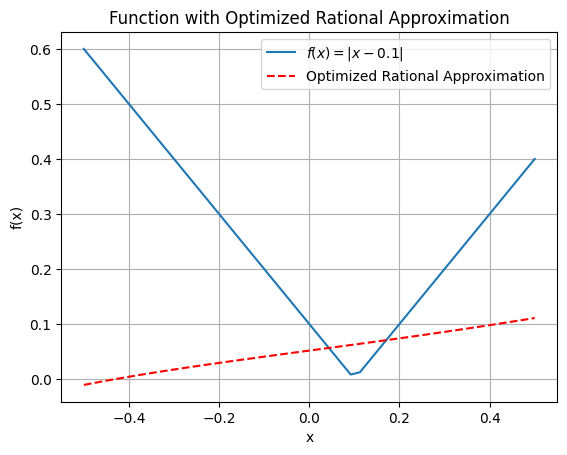

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

# Define the function to approximate
def target_function(x):
    return np.abs(x - 0.1)

# Rational approximation function
def rational_approximation(x, p, q):
    p_x = sum(p[i] * x**i for i in range(len(p)))
    q_x = sum(q[i] * x**i for i in range(len(q)))
    return p_x / q_x if q_x != 0 else np.inf  # Avoid division by zero

# Function to evaluate Chebyshev polynomials for given coefficients
def chebyshev_polynomial_eval(coeffs, x, degree, a, b):
    T = np.zeros(len(x))
    bma = 0.5 * (b - a)
    bpa = 0.5 * (b + a)
    x_scaled = (x - bpa) / bma
    T_0, T_1 = np.ones(len(x)), x_scaled
    if degree > 0:
        T += coeffs[0] * T_0
    if degree > 1:
        T += coeffs[1] * T_1
    for n in range(2, degree):
        T_2 = 2 * x_scaled * T_1 - T_0
        T += coeffs[n] * T_2
        T_0, T_1 = T_1, T_2
    return T

# Optimization function to find rational approximation coefficients
def rational_min_max_opt(f, n, m, pts, LB, UB, a, b, precision):
    # Define the Chebyshev "Vandermonde" matrices for p and q coefficients
    Tn = np.zeros((len(pts), n))
    Tm = np.zeros((len(pts), m))

    for deg in range(n):
        coeffs = np.zeros(n)
        coeffs[deg] = 1
        Tn[:, deg] = chebyshev_polynomial_eval(coeffs, pts, n, a, b)

    for deg in range(m):
        coeffs = np.zeros(m)
        coeffs[deg] = 1
        Tm[:, deg] = chebyshev_polynomial_eval(coeffs, pts, m, a, b)

    # Bisection bounds
    uL = 0
    uH = max(np.abs(f(pts) - np.mean(f(pts))))  # Initial upper bound

    while (uH - uL) > precision:
        z = (uH + uL) / 2
        if check_feasibility(f, z, n, m, pts, Tn, Tm, LB, UB):
            uH = z
        else:
            uL = z

    # Obtain final optimized p and q coefficients
    p_opt, q_opt, _ = solve_lp(f, uH, n, m, pts, Tn, Tm, LB, UB)
    return p_opt, q_opt

# Feasibility check for current z value
def check_feasibility(f, z, n, m, pts, Tn, Tm, LB, UB):
    _, _, feasible = solve_lp(f, z, n, m, pts, Tn, Tm, LB, UB)
    return feasible

# Solve linear programming for given z to find p and q
def solve_lp(f, z, n, m, pts, Tn, Tm, LB, UB):
    num_vars = n + m + 1
    c = np.zeros(num_vars)
    c[-1] = 1  # Objective to minimize last variable θ

    # Constraints matrix A and vector b
    A = np.zeros((2 * len(pts) + 2 * m, num_vars))
    b = np.zeros(2 * len(pts) + 2 * m)

    f_pts = f(pts)
    for i in range(len(pts)):
        A[i, :n] = Tn[i, :]
        A[i, n:n + m] = -f_pts[i] * Tm[i, :]
        A[i, -1] = -1
        b[i] = -f_pts[i] + z

        A[len(pts) + i, :n] = -Tn[i, :]
        A[len(pts) + i, n:n + m] = f_pts[i] * Tm[i, :]
        A[len(pts) + i, -1] = -1
        b[len(pts) + i] = f_pts[i] + z

    # Bounds for p and q coefficients in the remaining rows of A
    for j in range(m):
        A[2*len(pts) + j, n + j] = -1
        b[2*len(pts) + j] = -LB

        A[2*len(pts) + m + j, n + j] = 1
        b[2*len(pts) + m + j] = UB

    # Linear programming to minimize θ
    res = linprog(c, A_ub=A, b_ub=b, method="highs")

    if res.success:
        p_opt = res.x[:n]
        q_opt = res.x[n:n + m]
        return p_opt, q_opt, True
    else:
        return None, None, False

# Main part to run the rational approximation
# Define parameters
a, b = -0.5, 0.5
n, m = 4, 4
precision = 1e-6
LB, UB = 0.1, 50
num_points = 50
x_points = np.linspace(a, b, num_points)
y_values = target_function(x_points)

# Calculate the rational approximation coefficients
p_optimal, q_optimal = rational_min_max_opt(target_function, n, m, x_points, LB, UB, a, b, precision)

# Evaluate the rational approximation across the points
optimized_rational_values = np.array([rational_approximation(x, p_optimal, q_optimal) for x in x_points])

# Plot the target function and its rational approximation
plt.plot(x_points, y_values, label=r"$f(x) = |x - 0.1|$")
plt.plot(x_points, optimized_rational_values, 'r--', label="Optimized Rational Approximation")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Function with Optimized Rational Approximation")
plt.legend()
plt.grid(True)
plt.show()